# TOPP-HATT

In some cases, we want to optimise an encoding without changing the underlying tree structure. For instance, we may want to use exactly the tree output from the [Bonsai Algorithm](https://ferrmion.readthedocs.io/en/latest/notebooks/bonsai.html).

`ferrmion` lets you do this with the `topphatt` algorithm.

This notebook demonstrates the benefits of the method, for simple examples of how to use it, please see the documentation on [encoding Hamiltonians with ferrmion.](https://ferrmion.readthedocs.io/en/latest/notebooks/encoding_hamiltonians.html).

For more details, see our [preprint](https://arxiv.org/abs/2512.13580).

In [1]:
from ferrmion import core
from ferrmion.utils import fermionic_to_sparse_majorana
from ferrmion.core import anneal_enumerations, encode
from ferrmion.optimize import topphatt
from ferrmion.encode import TernaryTree

import numpy.random as rng
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path
from copy import deepcopy
import json

We'll start as always by loading in some one and two electron integrals.

In [2]:

folder = Path.cwd().joinpath(Path("../../../python/tests/data/"))

with open(folder.joinpath("h2o_sto-3g.json"), 'r') as file:
    data = json.load(file)

ones = np.array(data["ones"])
twos = np.array(data["twos"])
enuc = data["constant_energy"]

In [3]:
def pauli_weights(pauli_hamiltonian: dict[str, float]) -> list[float]:
    unscaled_terms = []
    scaled_terms = []
    for k, v in pauli_hamiltonian.items():
        assert v != 0
        pw = (len(k) - k.count("I")) 
        unscaled_terms.append(pw)
        scaled_terms.append(pw* np.abs(v))

    return (int(np.sum(unscaled_terms)), float(np.sum(scaled_terms)), len(pauli_hamiltonian))

In [4]:
from ferrmion.core import flatpack_symplectic_matrix
from ferrmion.encode.ternary_tree import TTFlatpack
from os import name
def get_naive_result(tree:TernaryTree, ones, twos, enuc):
    print("Getting Naive result...")
    sdmeans_naive = {}
    ipow, sym = tree._build_symplectic_matrix()
    result = pauli_weights(encode(ipow, sym, ["+-","++--"], [ones, twos], enuc))
    print("Naive result:", result)

    sdmeans_naive = {}
    sdmeans_naive["unscaled"] = result[0]
    sdmeans_naive["scaled"] = result[1]
    sdmeans_naive["length"] = result[2]
    return sdmeans_naive

def get_permuation_results(flatpack, ones, twos, enuc, limit):
    print(f"\nGetting {limit} random results...")
    sdmeans = {}
    sdmeans = {"unscaled":[], "scaled":[], "length":[]}
    ipow, sym = flatpack_symplectic_matrix(flatpack)
    rng = np.random.default_rng(1017)
    
    for i in range(limit):
        if i % 100 == 0:
            print(i)
        perm = rng.permutation(ones.shape[0])
        perm_index = np.ravel(np.column_stack((2*perm, 2*perm +1)))
        result = pauli_weights(encode(ipow[perm_index], sym[perm_index], ["+-", "++--"], [ones, twos], enuc))
        sdmeans["unscaled"].append(result[0]) 
        sdmeans["scaled"].append(result[1])
        sdmeans["length"].append(result[2]) 
        
    print("Permutation Results")

    return sdmeans

def get_annealed_result(flatpack, ones, twos, enuc, coef_weight):
    print("\nGetting Annealed result...")
    sdmeans_annealed = {}
    sdmeans_annealed = {"unscaled":[], "scaled":[], "length":[]}
    ipow, sym = flatpack_symplectic_matrix(flatpack)
    print("Beginning Annealing")
    anneal_ipow, anneal_sym = anneal_enumerations(ipowers=ipow, symplectics=sym, signatures=["+-","++--"], coeffs=[ones, twos], temperature=ones.shape[0], initial_guess=np.array([*range(ones.shape[0])],dtype=np.uint), coefficient_weighted=coef_weight)
    print("Finished annealing.")
    anneal_ham = encode(anneal_ipow, anneal_sym, ["+-","++--"], [ones, twos], enuc)
    result = pauli_weights(anneal_ham)
    print("Annealed result:", result)
    sdmeans_annealed["unscaled"].append(result[0])
    sdmeans_annealed["scaled"].append(result[1])
    sdmeans_annealed["length"].append(result[2])
    return sdmeans_annealed

def get_rust_topphatt_result(flatpack, ones, twos, enuc):
    print("\nRunning rust TOPP-HATT...")
    n_modes = ones.shape[0]
    ipow,sym = core.topphatt(flatpack, n_qubits=n_modes,signatures=["+-","++--"], coeffs=[ones, twos])
        
    print("\nGetting rust TOPP-HATT result...")
    result = pauli_weights(encode(ipow, sym, ["+-","++--"],[ones,twos],enuc))
    print("TOPP-HATT result:", result)
    
    sdmeans_topphatt = {}
    sdmeans_topphatt["unscaled"] = result[0]
    sdmeans_topphatt["scaled"] = result[1]
    sdmeans_topphatt["length"] = result[2]
    return sdmeans_topphatt

def get_topp_hatt_results(tree: TernaryTree, name, ones, twos, enuc, limit=250, save=False):
    flatpack = tree.flatpack()

    initial_ones = deepcopy(ones)
    initial_twos = deepcopy(twos)

    sdmeans_naive = get_naive_result(tree, ones, twos, enuc)
    sdmeans = get_permuation_results(flatpack, ones, twos, enuc, limit)

    sdmeans_annealed_pw = get_annealed_result(flatpack, ones, twos, enuc, False)
    sdmeans_annealed_cpw = get_annealed_result(flatpack, ones, twos, enuc, True)

    sdmeans_topphatt = get_rust_topphatt_result(flatpack, ones, twos, enuc) 

    color_set = {"jw":"tab:blue", "pe":"tab:orange", "bk":"tab:green", "jkmn":"tab:red", "bonsai":"tab:purple", "huffman":"tab:brown", "hatt":"tab:pink"}
    fig, ax = plt.subplots(layout="constrained")

    ax.scatter(sdmeans["unscaled"], sdmeans["scaled"], label="Randomised Permutations", marker=".", color="tab:grey", alpha=0.7)
    ax.plot(sdmeans_naive["unscaled"], sdmeans_naive["scaled"], marker="D", color="tab:red", mec="k", markersize=8)
    ax.plot(sdmeans_annealed_pw["unscaled"], sdmeans_annealed_pw["scaled"], marker="P", color="tab:orange", mec="k", markersize=8)
    ax.plot(sdmeans_annealed_cpw["unscaled"], sdmeans_annealed_cpw["scaled"], marker="X", color="tab:orange", mec="k", markersize=8)
    ax.plot(sdmeans_topphatt["unscaled"], sdmeans_topphatt["scaled"], marker="P", color="tab:green", mec="k", markersize=8)
    # ax.plot(sdmeans_topphatt_py["unscaled"], sdmeans_topphatt_py["scaled"], marker="X", color="tab:blue", mec="k", markersize=8)

    # where some data has already been plotted to ax
    handles, labels = plt.gca().get_legend_handles_labels()
    # manually define a new patch 
    naive_legend = mlines.Line2D([], [], label='Naive Enumeration', marker="D", linestyle="", color="tab:red", mec="k", markersize=8)
    annealed_pw_legend = mlines.Line2D([], [], label='$W_{P}$ Annealed Best', marker="P", linestyle="",color="tab:orange", mec="k", markersize=8)
    annealed_cpw_legend = mlines.Line2D([], [], label='$W_{CP}$ Annealed Best', marker="X", linestyle="",color="tab:orange", mec="k", markersize=8)
    topphatt_legend = mlines.Line2D([], [], label='TOPP-HATT-Rust', marker="P", linestyle="",color="tab:green", mec="k", markersize=8)

    assert np.all(initial_ones == ones)
    assert np.all(initial_twos == twos)

    data = {"random":sdmeans, "naive":sdmeans_naive, "annealed_pw":sdmeans_annealed_pw, "annealed_cpw":sdmeans_annealed_cpw, "topphatt":sdmeans_topphatt}
    if save:
        with open(f"{name}.json", "w+") as f:
            json.dump(data, f)

    # handles is a list, so append manual patch
    handles.extend([
                    naive_legend,
                    annealed_pw_legend, 
                    annealed_cpw_legend, 
                    topphatt_legend,
                    ])

    ax.set_xlabel("unscaled pauli-weight")
    ax.set_ylabel("coefficient scaled pauli-weight")
    ax.set_title(f"{name} Encodings of $H_2 O$:$STO-3G$")
    fig.legend(handles=handles, loc="outside lower center", ncols=len(handles)//2)
    fig.show()



# Standard Encodings

Getting Naive result...
Naive result: (14756, 191.34214293107772, 2034)

Getting 250 random results...
0
100
200
Permutation Results

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (10908, 145.8016824232816, 2034)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (13708, 143.17592165400052, 2034)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (10932, 145.04364613711397, 2034)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_64025/4163261852.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


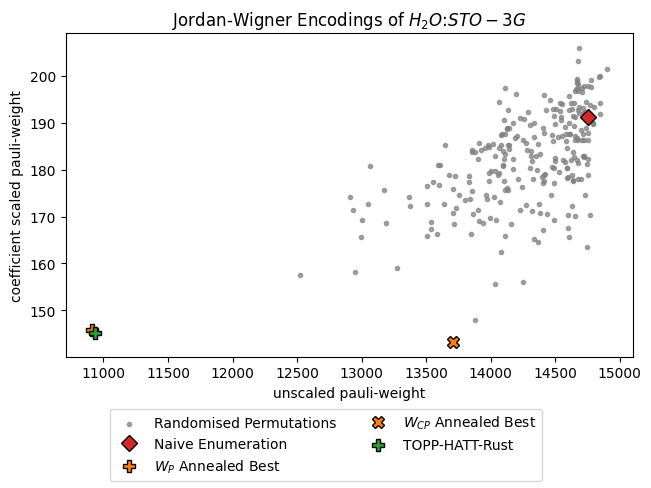

In [5]:
from ferrmion.encode.ternary_tree import JordanWigner
get_topp_hatt_results(JordanWigner(ones.shape[0]),"Jordan-Wigner", ones, twos, enuc)

Getting Naive result...
Naive result: (15047, 256.80196979954786, 2034)

Getting 250 random results...
0
100
200
Permutation Results

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (11734, 213.62940872336725, 2034)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (13582, 194.42788272644813, 2034)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (11422, 212.92878182329943, 2034)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_64025/4163261852.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


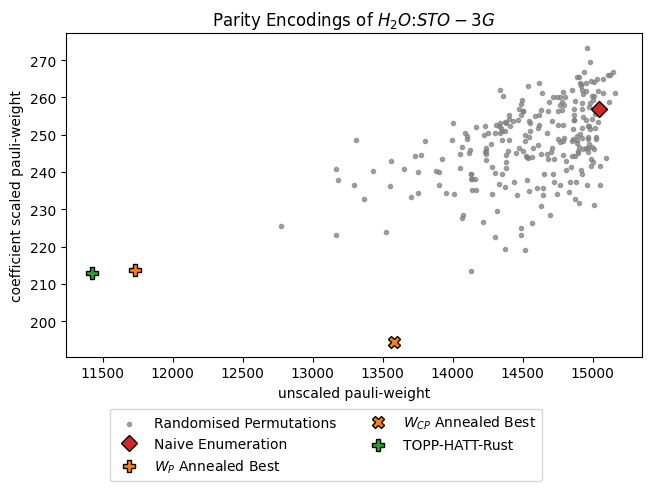

In [6]:
from ferrmion.encode.ternary_tree import ParityEncoding
get_topp_hatt_results(ParityEncoding(ones.shape[0]),"Parity", ones, twos, enuc)


Getting Naive result...
Naive result: (12656, 292.03224577227707, 2034)

Getting 250 random results...
0
100
200
Permutation Results

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (11223, 231.23910939632674, 2034)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (12394, 180.06267284951608, 2034)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (12470, 194.68983960393956, 2034)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_64025/4163261852.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


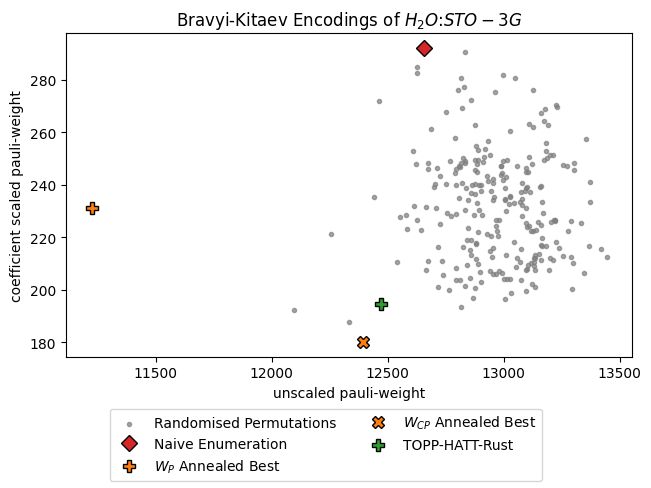

In [7]:
from ferrmion.encode.ternary_tree import BravyiKitaev
get_topp_hatt_results(BravyiKitaev(ones.shape[0]),"Bravyi-Kitaev", ones, twos, enuc)

Getting Naive result...
Naive result: (12702, 277.78889028925477, 2034)

Getting 250 random results...
0
100
200
Permutation Results

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (11737, 180.16692453586694, 2034)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (12268, 180.3099345862293, 2034)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (11894, 215.16128752101156, 2034)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_64025/4163261852.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


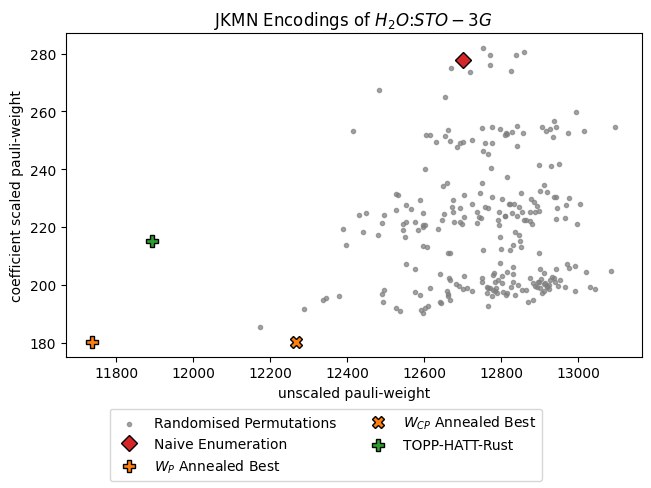

In [8]:
from ferrmion.encode.ternary_tree import JKMN
get_topp_hatt_results(JKMN(ones.shape[0]),"JKMN", ones, twos, enuc)


# Hamiltonian Optimized Trees

TOPP-HATT can be applied to any ternary tree,  including those which are derived from other optimisation methods.

In [9]:
from ferrmion.optimize import huffman_ternary_tree

huffman_tree = huffman_ternary_tree(ones, twos)

Getting Naive result...
Naive result: (12990, 206.95335127851803, 2034)

Getting 250 random results...
0
100
200
Permutation Results

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (12114, 197.82136690401967, 2034)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (12251, 181.2741411370368, 2034)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (12287, 194.88341009411636, 2034)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_64025/4163261852.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


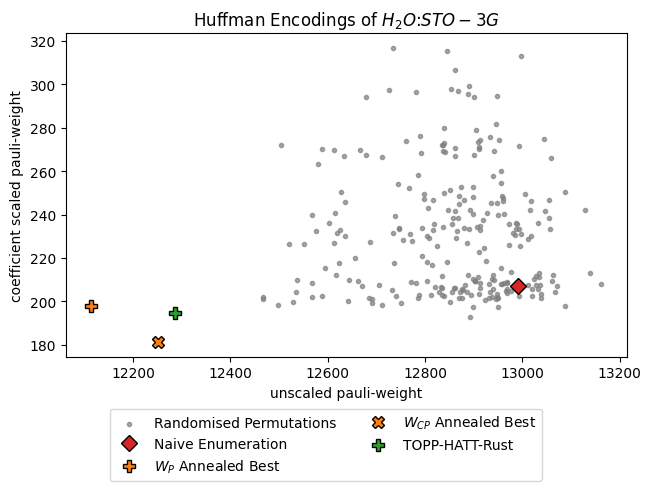

In [10]:
huffman_topphatt = get_topp_hatt_results(huffman_tree, name="Huffman", ones=ones,twos=twos,enuc=enuc)

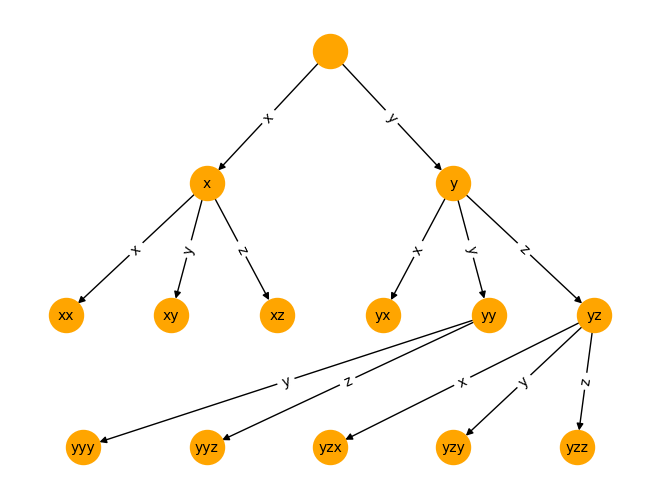

In [11]:
from ferrmion.visualise import draw_tt
draw_tt(huffman_tree)

Getting Naive result...
Naive result: (13101, 221.15679453712704, 2034)

Getting 250 random results...
0
100
200
Permutation Results

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (11324, 188.3238676336287, 2034)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (12651, 168.85043272091724, 2034)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (12448, 189.9459916504694, 2034)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_64025/4163261852.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


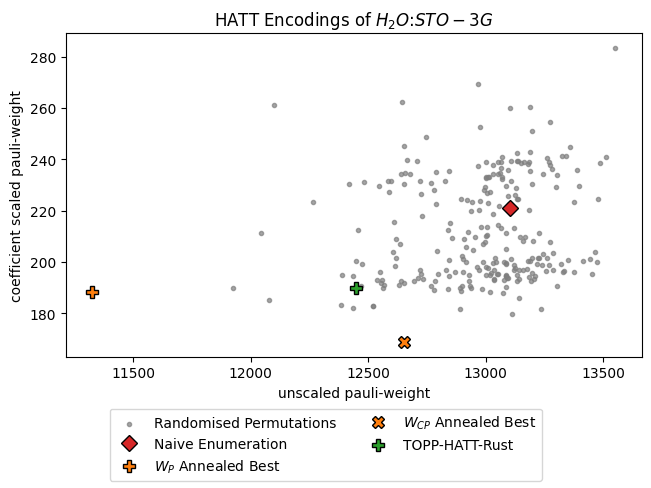

In [12]:
from ferrmion.optimize.hatt import hamiltonian_adaptive_ternary_tree
sparse_ham = fermionic_to_sparse_majorana([(ones, "+-"), (twos,"++--")])
hatt_tree = hamiltonian_adaptive_ternary_tree(deepcopy(sparse_ham), ones.shape[0])
get_topp_hatt_results(hatt_tree, "HATT", ones=ones, twos=twos, enuc=enuc)

(None,
 {'': (0, 13),
  'x': (1, 5),
  'y': (2, 6),
  'z': (3, 12),
  'zx': (4, 11),
  'zz': (5, 2),
  'zxx': (6, 10),
  'zxy': (7, 8),
  'zzz': (8, 1),
  'zxxx': (9, 3),
  'zxxy': (10, 9),
  'zxxz': (11, 7),
  'zzzz': (12, 0),
  'zxxyz': (13, 4)})

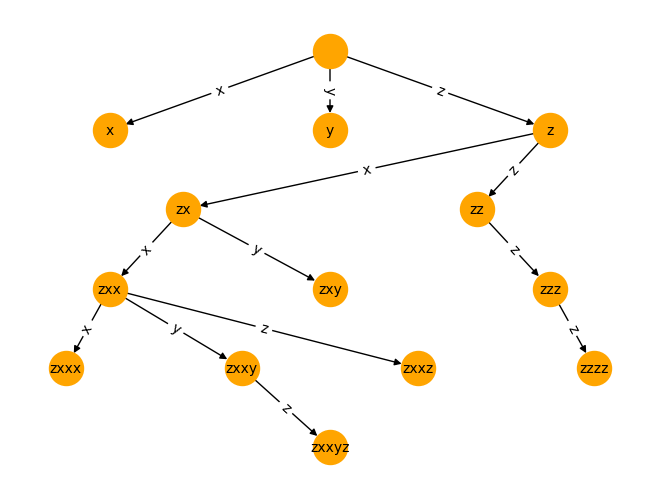

In [13]:
draw_tt(hatt_tree), hatt_tree.enumeration_scheme

# Device Optimized Trees

In [14]:
import rustworkx as rx
from rustworkx import visualization as rxv
import matplotlib.pyplot as plt
import numpy as np
def heavy_hex_graph():
    graph = rx.PyGraph()
    graph.add_nodes_from(range(ones.shape[0]))
    graph.add_edges_from_no_data(
        [(a,b) for a, b in [
            (0, 1),
            (0, 2),
            (0, 3),
            (1, 4),
            (2, 5),
            (3, 6),
            (4, 7),
            (4, 8),
            (5, 9),
            (5, 10),
            (6, 11),
            (6, 12),
            (7, 13),
            (8, 14),
            (9, 15),
            (10, 16),
            (11, 17),
            (12, 18),
            (13, 19),
            (13, 20),
            (14, 21),
            (14, 22),
            (15, 23),
            (15, 24),
            (16, 25),
            (16, 26),
            (17, 27),
            (17, 28),
            (18, 29),
            (18, 30),
            (22, 31),
            (26, 32),
            (30, 33),
            (31, 34),
            (32, 35),
            (33, 36),
        ] if a<ones.shape[0] and b <ones.shape[1]]
    )
    return graph

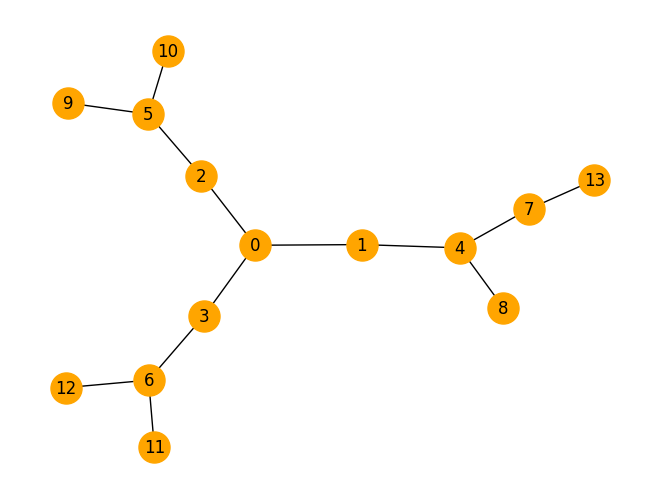

In [15]:
graph = heavy_hex_graph()
rxv.mpl_draw(graph, with_labels=True, node_color="orange", node_size=500)

Getting Naive result...
Naive result: (13584, 280.2418348673023, 2034)

Getting 250 random results...
0
100
200
Permutation Results

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (12219, 180.58489800725405, 2034)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (13139, 178.8895898453614, 2034)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (12549, 181.37038252890787, 2034)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_64025/4163261852.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


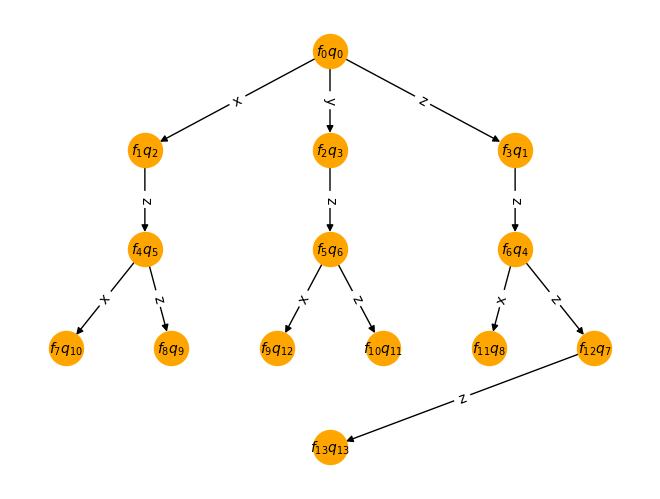

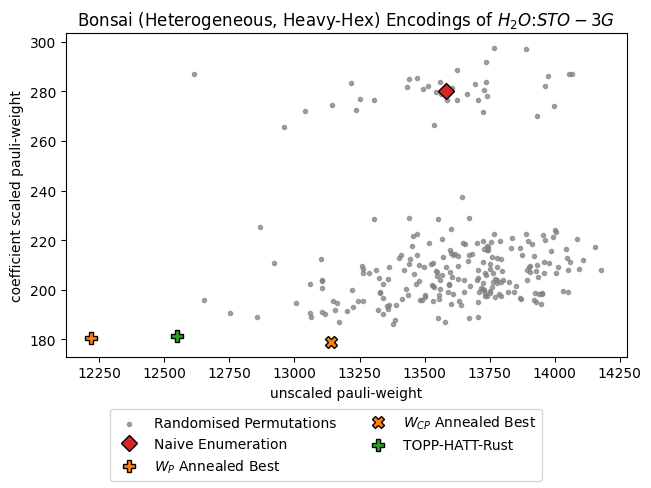

In [16]:
from ferrmion.visualise import draw_tt
from ferrmion.optimize import bonsai_algorithm
bonsai= bonsai_algorithm(graph=graph, homogenous=False)
draw_tt(bonsai, type="spaced", enumeration_scheme=bonsai.default_enumeration_scheme())
get_topp_hatt_results(bonsai, name="Bonsai (Heterogeneous, Heavy-Hex)", ones=ones, twos=twos, enuc=enuc)

Getting Naive result...
Naive result: (13954, 254.06491556198836, 2034)

Getting 250 random results...
0
100
200
Permutation Results

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (12192, 190.8821214229613, 2034)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (13384, 185.00365275355503, 2034)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (12949, 224.0347437100013, 2034)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_64025/4163261852.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


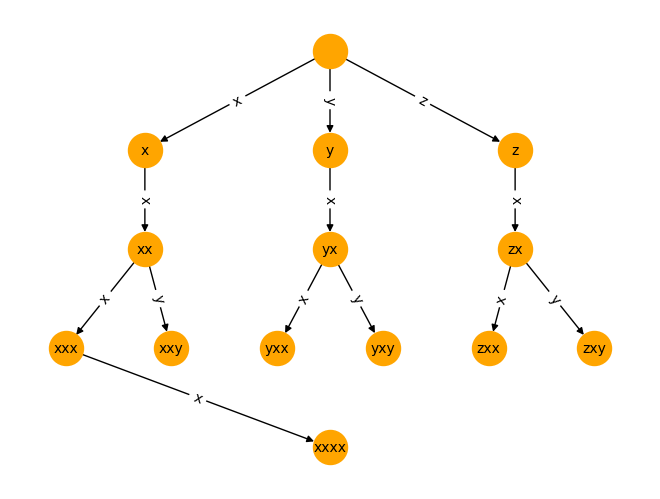

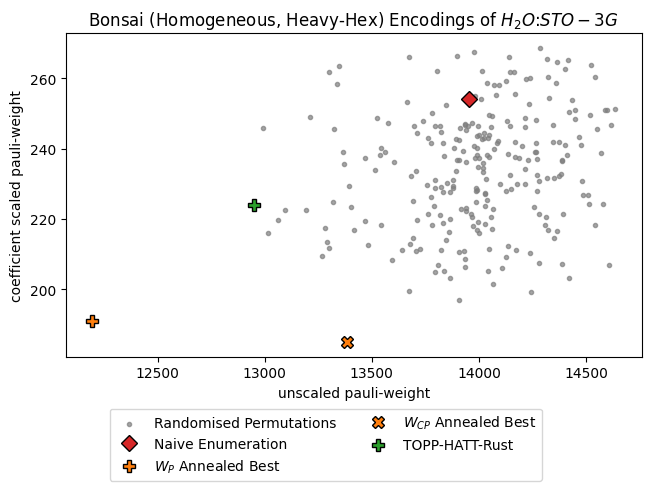

In [17]:
from ferrmion.optimize import bonsai_algorithm
bonsai= bonsai_algorithm(graph=graph, homogenous=True)
draw_tt(bonsai, type="spaced")
get_topp_hatt_results(bonsai, name="Bonsai (Homogeneous, Heavy-Hex)", ones=ones, twos=twos,  enuc=enuc)